### tx volcano plots and venn diagrams

First I need to assemble the data from xtail (fold changes and p values)

In [1]:
#set up imports, define some functions
import pandas as pd
import numpy as np
import math
import sys
pipeline_dir = '../ribo_seq/'
if pipeline_dir not in sys.path:
    sys.path.append(pipeline_dir)
import ribo_utils
comprehensive_gtf_data = ribo_utils.gtf_data('../annotations/gencode.v35.annotation.pBZ105.no_nonstop.gtf', add_3_for_stop=True)
genome_seq = ribo_utils.genome_sequence('../annotations/genome/GRCh38.primary_assembly.genome.pBZ105.fa')
def extract_gene_id(x):
    info_parts = x.split('|')
    return info_parts[0]

def extract_gene_name(x):
    info_parts = x.split('|')
    return info_parts[1]

def get_gene_id(x):
    if '|' in x:
        return get_gene_id(x.split('|')[0])
    return comprehensive_gtf_data.tx_to_genes[x]

def get_gene_name(x):
    if '|' in x:
        return get_gene_name(x.split('|')[0])
    return comprehensive_gtf_data.tx_to_gene_names[x]

def log_trans(x):
    try:
        return math.log(x, 10)
    except:
        return float('NaN')

def get_stop_codon(x, upstream=0, downstream=0):
    transcript_seq = comprehensive_gtf_data.transcript_sequence(genome_seq, x, exon_type='exon')
    cds_start, cds_end = comprehensive_gtf_data.cds_boundaries(x)
    stop_seq = transcript_seq[cds_end-(2+upstream): cds_end+1+downstream] #have to point 1 past end positions
    return stop_seq

In [2]:
#matplotlib setup
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from adjustText import adjust_text
import math

mpl.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

black = (0,0,0)
gray = (0.5,0.5,0.5)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
colors = [black, orange, skyBlue, bluishGreen, vermillion, blue, reddishPurple, yellow]
rainbow = [black, vermillion, orange, bluishGreen, blue, reddishPurple, 'violet']

In [17]:
#get data from xtail analysis
#KO effects in DMSO
SMG1i_vs_DMSO = pd.read_csv('../5_run_xtail/xtail_results/xtail_SMG1i_mono_RNA.tsv', sep='\t')
EIF4E2_in_DMSO = pd.read_csv('../5_run_xtail/xtail_results/xtail_eIF4E2_in_DMSO_mono_RNA.tsv', sep='\t')
GIGYF2_in_DMSO = pd.read_csv('../5_run_xtail/xtail_results/xtail_GIGYF2_in_DMSO_mono_RNA.tsv', sep='\t')

significance_datasets = [SMG1i_vs_DMSO, EIF4E2_in_DMSO, GIGYF2_in_DMSO]
for dataset in significance_datasets:
    dataset.rename(columns={'Unnamed: 0': 'tx_id'}, inplace=True)
    dataset['gene_name'] = dataset['tx_id'].apply(get_gene_name)
    dataset['minus logpadj'] = dataset['pvalue.adjust'].apply(log_trans)*-1

In [18]:
from collections import defaultdict
dataset_names = ['SMG1ivDMSO', 'EIF4E2dvWT', 'GIGYF2dvWT']
padj_cutoff = 0.1
hits_by_dataset = defaultdict(list)
datasets_by_hit = defaultdict(list)
for comparison_index  in range(len(significance_datasets)):
    dataset_name = dataset_names[comparison_index]
    sig_dataset = significance_datasets[comparison_index]
    sig_p_up = sig_dataset[(sig_dataset['pvalue.adjust']<=padj_cutoff) & (sig_dataset['log2FC_TE_final']>0)]
    sig_tx = sig_p_up['tx_id'].tolist()
    print(len(sig_tx), len(set(sig_tx)))
    for tx in sig_tx:
        hits_by_dataset[dataset_name].append(tx)
        datasets_by_hit[tx].append(dataset_name)


(275, 275)
(65, 65)
(64, 64)


In [19]:
all_hits = set(hits_by_dataset['SMG1ivDMSO']).union(set(hits_by_dataset['GIGYF2dvWT'])).union(set(hits_by_dataset['EIF4E2dvWT']))

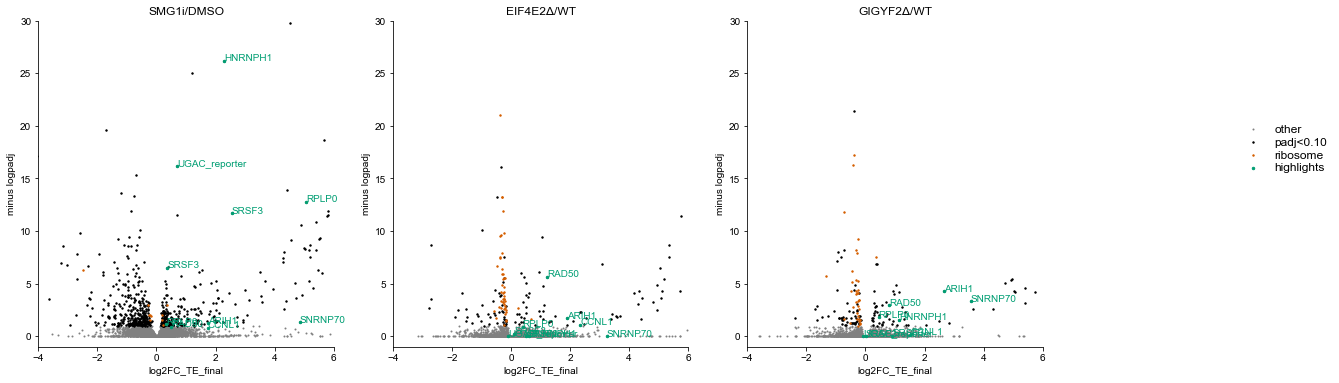

In [23]:
#first make volcano plots for major 3 comparisons - EDF1 vs WT and emetine treatments
significance_datasets = [SMG1i_vs_DMSO, EIF4E2_in_DMSO, GIGYF2_in_DMSO]
dataset_names = ['SMG1i/DMSO', u'EIF4E2Δ/WT', u'GIGYF2Δ/WT']
padj_cutoff = 0.1

x_var = 'log2FC_TE_final'
y_var = 'minus logpadj'

num_plots_wide = len(significance_datasets)
num_plots_high = 1
fig = plt.figure(figsize=(6*num_plots_wide, 6*num_plots_high))
plot_index = 1

for comparison_index  in range(len(significance_datasets)):
    plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
    
    #pull out significant hits
    sig_dataset = significance_datasets[comparison_index]
    sig_p = sig_dataset[sig_dataset['pvalue.adjust']<padj_cutoff]
    translation = sig_p[sig_p['gene_name'].str.startswith('RPS') | sig_p['gene_name'].str.startswith('RPL')]
    sig_p = sig_p[~sig_p['gene_name'].isin(translation['gene_name'])]
    insig_p = sig_dataset[sig_dataset['pvalue.adjust']>padj_cutoff]
    #reporter = sig_dataset[sig_dataset['gene_name'].isin(['UGAC_reporter'])]
    highlight = sig_dataset[(sig_dataset['tx_id'].isin(all_hits)) & (sig_dataset['gene_name'].isin(['CCNL1', 'SRSF3', 'SNRNP70', 'ARIH1', 'RPLP0', 'HNRNPH1','RAD50', 'UGAC_reporter']))]
    #make scatterplots
    insig_p.plot.scatter(x_var, y_var, color=gray, s=1, alpha=1, ax=plot, label='other')
    sig_p.plot.scatter(x_var, y_var, color=black, s=2, alpha=1, ax=plot, label='padj<%.2f' %(padj_cutoff))
    translation.plot.scatter(x_var, y_var, color=vermillion, s=2, alpha=1, ax=plot, label='ribosome')
    #reporter.plot.scatter(x_var, y_var, color=skyBlue, s=6, alpha=1, ax=plot, label='reporter')
    highlight.plot.scatter(x_var, y_var, color=bluishGreen, s=6, alpha=1, ax=plot, label='highlights')
    
    
    #label most significant hits
    #top_hits = sig_p[sig_p['log2FC_TE_final']>0]
    #top_hits = sig_p
    #top_hits = top_hits[~top_hits['gene_name'].isin(highlight['gene_name'])].sort_values(by=['pvalue.adjust'])[:5]
    #texts = []
    #for x, y, s in zip(top_hits[x_var], top_hits[y_var], top_hits['gene_name']):
    #    texts.append(plot.text(x, y, s))
    #    adjust_text(texts, only_move={'points':'y', 'text':'y'})
    top_hits = highlight
    texts = []
    for x, y, s in zip(top_hits[x_var], top_hits[y_var], top_hits['gene_name']):
        texts.append(plot.text(x, y, s, color=bluishGreen))
        #adjust_text(texts, only_move={'points':'y', 'text':'y'})
    
    #adjust axes
    plot.set_title(dataset_names[comparison_index])
    plot.set_xlabel(x_var)
    plot.set_ylabel(y_var)
    #plot.set_xscale('log', basex=2)
    #plot.set_yscale('log', basey=2)
    plot.set_ylim(-1, 30)
    plot.set_xlim(-4, 6)
    plot.spines['right'].set_visible(False)
    plot.spines['top'].set_visible(False)
    #plot.set_aspect('equal')
    plot.get_legend().remove()
    plot_index+=1

lg=plot.legend(prop={'size':12}, labelspacing=0.2, bbox_to_anchor=(2,0.5), loc="lower right")
lg.draw_frame(False)
#plt.tight_layout()
plt.savefig('volcano_GIGYF2_4E2_SMG1i_uplabel.pdf', transparent='True', format='pdf', bbox_inches='tight')
plt.savefig('volcano_GIGYF2_4E2_SMG1i_uplabel.png', transparent='True', format='png', bbox_inches='tight')

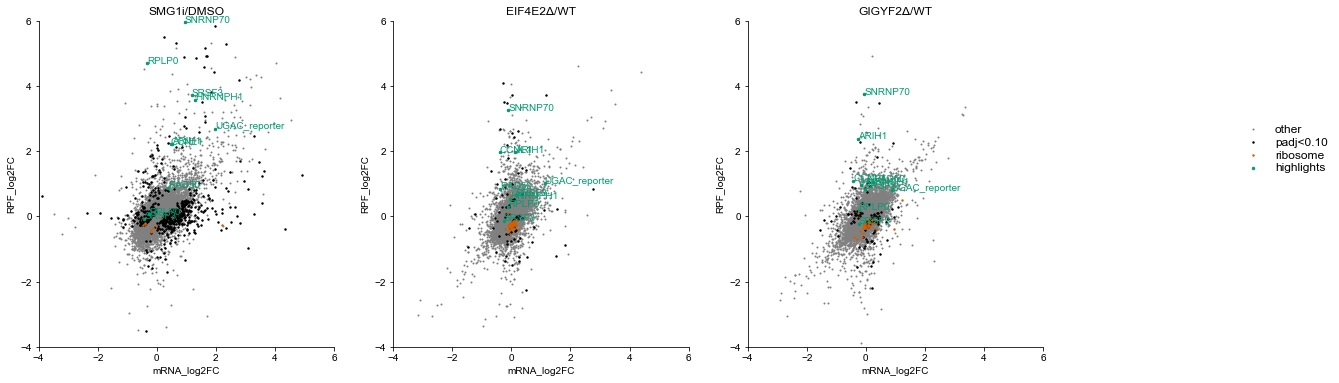

In [24]:
#first make volcano plots for major 3 comparisons - EDF1 vs WT and emetine treatments
significance_datasets = [SMG1i_vs_DMSO, EIF4E2_in_DMSO, GIGYF2_in_DMSO]
dataset_names = ['SMG1i/DMSO', u'EIF4E2Δ/WT', u'GIGYF2Δ/WT']
padj_cutoff = 0.1

x_var = 'mRNA_log2FC'
y_var = 'RPF_log2FC'

num_plots_wide = len(significance_datasets)
num_plots_high = 1
fig = plt.figure(figsize=(6*num_plots_wide, 6*num_plots_high))
plot_index = 1

for comparison_index  in range(len(significance_datasets)):
    plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
    
    #pull out significant hits
    sig_dataset = significance_datasets[comparison_index]
    sig_p = sig_dataset[sig_dataset['pvalue.adjust']<padj_cutoff]
    translation = sig_p[sig_p['gene_name'].str.startswith('RPS') | sig_p['gene_name'].str.startswith('RPL')]
    sig_p = sig_p[~sig_p['gene_name'].isin(translation['gene_name'])]
    insig_p = sig_dataset[sig_dataset['pvalue.adjust']>padj_cutoff]
    #reporter = sig_dataset[sig_dataset['gene_name'].isin(['UGAC_reporter'])]
    highlight = sig_dataset[(sig_dataset['tx_id'].isin(all_hits)) & (sig_dataset['gene_name'].isin(['CCNL1', 'SRSF3', 'SNRNP70', 'ARIH1', 'RPLP0', 'HNRNPH1','RAD50', 'UGAC_reporter']))]
    #make scatterplots
    insig_p.plot.scatter(x_var, y_var, color=gray, s=1, alpha=1, ax=plot, label='other')
    sig_p.plot.scatter(x_var, y_var, color=black, s=2, alpha=1, ax=plot, label='padj<%.2f' %(padj_cutoff))
    translation.plot.scatter(x_var, y_var, color=vermillion, s=2, alpha=1, ax=plot, label='ribosome')
    #reporter.plot.scatter(x_var, y_var, color=skyBlue, s=6, alpha=1, ax=plot, label='reporter')
    highlight.plot.scatter(x_var, y_var, color=bluishGreen, s=6, alpha=1, ax=plot, label='highlights')
    
    
    #label most significant hits
    #top_hits = sig_p[sig_p['log2FC_TE_final']>0]
    top_hits = sig_p
    top_hits = top_hits[~top_hits['gene_name'].isin(highlight['gene_name'])].sort_values(by=['pvalue.adjust'])[:5]
    texts = []
    #for x, y, s in zip(top_hits[x_var], top_hits[y_var], top_hits['gene_name']):
    #    texts.append(plot.text(x, y, s))
    #    adjust_text(texts, only_move={'points':'y', 'text':'y'})
    top_hits = highlight
    texts = []
    for x, y, s in zip(top_hits[x_var], top_hits[y_var], top_hits['gene_name']):
        texts.append(plot.text(x, y, s, color=bluishGreen))
        #adjust_text(texts, only_move={'points':'y', 'text':'y'})
    
    #adjust axes
    plot.set_title(dataset_names[comparison_index])
    plot.set_xlabel(x_var)
    plot.set_ylabel(y_var)
    #plot.set_xscale('log', basex=2)
    #plot.set_yscale('log', basey=2)
    plot.set_ylim(-4, 6)
    plot.set_xlim(-4, 6)
    plot.spines['right'].set_visible(False)
    plot.spines['top'].set_visible(False)
    #plot.set_aspect('equal')
    plot.get_legend().remove()
    plot_index+=1

lg=plot.legend(prop={'size':12}, labelspacing=0.2, bbox_to_anchor=(2,0.5), loc="lower right")
lg.draw_frame(False)
#plt.tight_layout()
plt.savefig('scatter_by_tx_GIGYF2_4E2_SMG1i_uplabel.pdf', transparent='True', format='pdf', bbox_inches='tight')
plt.savefig('scatter_by_tx_GIGYF2_4E2_SMG1i_uplabel.png', transparent='True', format='png', bbox_inches='tight')

## Now write the groups to seperate and combined tables

In [25]:
f = open('hits_p0.1.tsv',  'w')
f.write(u'tx id\tgene\tstop tet\tpadj<0.1\n')
for tx in datasets_by_hit:
    f.write(u'%s\t%s\t%s\t%s\n' %(tx, get_gene_name(tx), get_stop_codon(tx, downstream=1),','.join(sorted(datasets_by_hit[tx]))))
f.close()

## Now make venn diagrams of the TE up groups

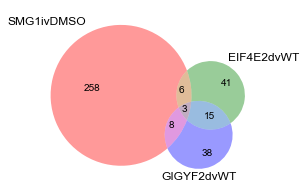

In [26]:
#plot overlaps
%matplotlib inline
from matplotlib_venn import venn3, venn2

dataset_names = ['SMG1ivDMSO', 'EIF4E2dvWT', 'GIGYF2dvWT']

figure, axes = plt.subplots(1, 1, figsize=(4, 4))
venn3([set(hits_by_dataset[dataset]) for dataset in dataset_names], (dataset for dataset in dataset_names), ax=axes)

plt.savefig('TE_up_venn.pdf', transparent=True, bbox_inches='tight')

## Now compute p values for overlaps

In [27]:
'''
M is the population size (previously N)
n is the number of successes in the population (previously K)
N is the sample size (previously n)
X is still the number of drawn “successes”.
We can then compute a probability of drawing X red marbles out of N from a jar containing n red marbles out of M in the following way:
from scipy.stats import hypergeom
pval = hypergeom.sf(x-1, M, n, N)
'''
from scipy.stats import hypergeom 

dataset_names = ['SMG1ivDMSO', 'EIF4E2dvWT', 'GIGYF2dvWT']
significance_datasets = [SMG1i_vs_DMSO, EIF4E2_in_DMSO, GIGYF2_in_DMSO]

background_set = set(SMG1i_vs_DMSO.dropna()['tx_id'].tolist()).intersection(set(EIF4E2_in_DMSO.dropna()['tx_id'].tolist())).intersection(set(GIGYF2_in_DMSO.dropna()['tx_id'].tolist()))
print('background set:', len(background_set))
GIGYF2_4E2_p = hypergeom.sf(len(set(hits_by_dataset['EIF4E2dvWT']).intersection(set(hits_by_dataset['GIGYF2dvWT'])))-1,
                            len(background_set), len(set(hits_by_dataset['EIF4E2dvWT'])),
                            len(set(hits_by_dataset['GIGYF2dvWT'])))
print("GIGYF2_4E2_p:", GIGYF2_4E2_p)
GIGYF2_SMG1i_p = hypergeom.sf(len(set(hits_by_dataset['GIGYF2dvWT']).intersection(set(hits_by_dataset['SMG1ivDMSO'])))-1,
                            len(background_set), len(set(hits_by_dataset['SMG1ivDMSO'])),
                            len(set(hits_by_dataset['GIGYF2dvWT'])))
print("GIGYF2_SMG1i_p:", GIGYF2_SMG1i_p)
EIF4E2_SMG1i_p = hypergeom.sf(len(set(hits_by_dataset['EIF4E2dvWT']).intersection(set(hits_by_dataset['SMG1ivDMSO'])))-1,
                            len(background_set), len(set(hits_by_dataset['SMG1ivDMSO'])),
                            len(set(hits_by_dataset['EIF4E2dvWT'])))
print("EIF4E2_SMG1i_p:", EIF4E2_SMG1i_p)

('background set:', 9750)
('GIGYF2_4E2_p:', 1.4897642014275047e-25)
('GIGYF2_SMG1i_p:', 1.4510700818860335e-06)
('EIF4E2_SMG1i_p:', 7.937610163618088e-05)
